# Next Event Prediction with LSTM and PM4PY

This notebook trains an LSTM neural network using PyTorch to predict the next event in a business process. We use `pm4py` to handle the event log data.

In [1]:
import pandas as pd
import numpy as np
import collections
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pm4py
import seaborn as sns
import matplotlib.pyplot as plt
import os
import copy
import time
from datetime import datetime

os.environ['PATH'] = '/opt/homebrew/bin/:' + os.environ['PATH']
!echo $PATH

%config InlineBackend.figure_format = 'retina'

# Set seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

log_file = 'BPI_Challenge_2019.xes.gz'
results_file = 'results.txt'

/opt/homebrew/bin/:/Users/sinan/anaconda3/bin:/Users/sinan/.antigravity/antigravity/bin:/Users/sinan/anaconda3/bin:/Users/sinan/anaconda3/condabin:/opt/homebrew/bin:/opt/homebrew/sbin:/usr/local/bin:/System/Cryptexes/App/usr/bin:/usr/bin:/bin:/usr/sbin:/sbin:/var/run/com.apple.security.cryptexd/codex.system/bootstrap/usr/local/bin:/var/run/com.apple.security.cryptexd/codex.system/bootstrap/usr/bin:/var/run/com.apple.security.cryptexd/codex.system/bootstrap/usr/appleinternal/bin:/opt/pmk/env/global/bin:/opt/X11/bin:/Library/TeX/texbin


In [2]:
# Select MPS device if available, otherwise fallback to CPU
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("✅ MPS device found. Using Apple Silicon GPU.")
else:
    device = torch.device("cpu")
    print("⚠️ MPS device not found. Using CPU.")

✅ MPS device found. Using Apple Silicon GPU.


## 0. Helper functions

In [3]:
def plot_case_count_vs_variants_size(EventLog):
    log_variants = pm4py.get_variants(EventLog)
    data = [(len(k),v) for k,v in log_variants.items()]
    grouped_sums = collections.defaultdict(int)
    for key, value in data:
        grouped_sums[key] += value
    Varients_cases_by_size = sorted([key, value] for key, value in grouped_sums.items())
    Varients_cases_by_size = [list(x) for x in zip(*Varients_cases_by_size)]
    plt.figure(figsize=(5, 3))
    plt.bar(Varients_cases_by_size[0], Varients_cases_by_size[1])
    plt.xlabel("Varients size (events)")
    plt.ylabel("Number of cases")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

def top_variants(eventlog):
    variants = pm4py.get_variants(eventlog)
    variants = dict(sorted(variants.items(), key=lambda item: item[1], reverse=True))
    
    total = sum(variants.values())
    cum = 0
    variants_pct = {}
    for k,v in variants.items():
        cum += v
        variants_pct[k] = cum/total

    return variants_pct

def filter_most_freq_pct_variants(eventlog, pct=0):
    n = 0
    variants_pct = top_variants(eventlog)
    for k,v in variants_pct.items():
        if v > pct:
            if n == 0: n=1
            break
        else:
            n += 1
    return pm4py.filter_variants_top_k(eventlog, n)

## 1. Load and Preprocess Data with PM4PY

We load the EventLog file and format it into a standard event log dataframe using `pm4py`.

In [4]:
# Load data
log_original = pm4py.read_xes(log_file)
log = copy.deepcopy(log_original)

# draw DFG
dfg, sa, ea = pm4py.discover_dfg(log_original)
# pm4py.view_dfg(dfg, sa, ea)
pm4py.save_vis_dfg(dfg, sa, ea, f'dfg_100.png')

# Standard PM4PY column names
case_col = 'case:concept:name'
act_col = 'concept:name'
time_col = 'time:timestamp'

display(log.head())

# Create Mappings
unique_activities = log[act_col].unique()
activity_to_idx = {act: i for i, act in enumerate(unique_activities)}
idx_to_activity = {i: act for act, i in activity_to_idx.items()}
vocab_size = len(unique_activities)

print(idx_to_activity)
print(f"Vocabulary: {vocab_size} activities")
print(f"Number of events: {len(log):,d}")
print(f"Number of cases: {len(pm4py.get_trace_attribute_values(log, "case:concept:name")):,d}")
print(f"Number of variants: {len(pm4py.get_variants(log)):,d}")

/Users/sinan/anaconda3/lib/python3.12/site-packages/pm4py/utils.py:959: UserWarning: In the current version, the import/export operation uses `rustxes` by default for importing/exporting files faster. Please uninstall `rustxes` to revert the behavior.
  warnings.warn("In the current version, the import/export operation uses `rustxes` by default for importing/exporting files faster. Please uninstall `rustxes` to revert the behavior.")


,case:Item Category,case:Sub spend area text,Cumulative net worth (EUR),case:Goods Receipt,User,case:Spend area text,case:Purchasing Document,case:GR-Based Inv. Verif.,case:concept:name,case:Vendor,...,org:resource,case:Name,case:Spend classification text,case:Item Type,time:timestamp,case:Purch. Doc. Category name,case:Document Type,case:Company,concept:name,case:Source
0,"3-way match, invoice before GR",Facility Management,298.0,True,batch_00,CAPEX & SOCS,2000000000,False,2000000000_00001,vendorID_0000,...,batch_00,vendor_0000,NPR,Standard,2018-01-02 12:53:00+00:00,Purchase order,EC Purchase order,companyID_0000,SRM: Created,sourceSystemID_0000
1,"3-way match, invoice before GR",Facility Management,298.0,True,batch_00,CAPEX & SOCS,2000000000,False,2000000000_00001,vendorID_0000,...,batch_00,vendor_0000,NPR,Standard,2018-01-02 13:53:00+00:00,Purchase order,EC Purchase order,companyID_0000,SRM: Complete,sourceSystemID_0000
2,"3-way match, invoice before GR",Facility Management,298.0,True,batch_00,CAPEX & SOCS,2000000000,False,2000000000_00001,vendorID_0000,...,batch_00,vendor_0000,NPR,Standard,2018-01-02 13:53:00+00:00,Purchase order,EC Purchase order,companyID_0000,SRM: Awaiting Approval,sourceSystemID_0000
3,"3-way match, invoice before GR",Facility Management,298.0,True,batch_00,CAPEX & SOCS,2000000000,False,2000000000_00001,vendorID_0000,...,batch_00,vendor_0000,NPR,Standard,2018-01-02 13:53:00+00:00,Purchase order,EC Purchase order,companyID_0000,SRM: Document Completed,sourceSystemID_0000
4,"3-way match, invoice before GR",Facility Management,298.0,True,batch_00,CAPEX & SOCS,2000000000,False,2000000000_00001,vendorID_0000,...,batch_00,vendor_0000,NPR,Standard,2018-01-02 13:53:00+00:00,Purchase order,EC Purchase order,companyID_0000,SRM: In Transfer to Execution Syst.,sourceSystemID_0000


{0: 'SRM: Created', 1: 'SRM: Complete', 2: 'SRM: Awaiting Approval', 3: 'SRM: Document Completed', 4: 'SRM: In Transfer to Execution Syst.', 5: 'SRM: Ordered', 6: 'SRM: Change was Transmitted', 7: 'Create Purchase Order Item', 8: 'Vendor creates invoice', 9: 'Record Goods Receipt', 10: 'Record Invoice Receipt', 11: 'Clear Invoice', 12: 'Record Service Entry Sheet', 13: 'SRM: Transfer Failed (E.Sys.)', 14: 'Cancel Goods Receipt', 15: 'Vendor creates debit memo', 16: 'Cancel Invoice Receipt', 17: 'Change Delivery Indicator', 18: 'Remove Payment Block', 19: 'SRM: Deleted', 20: 'Change Price', 21: 'Delete Purchase Order Item', 22: 'SRM: Transaction Completed', 23: 'Change Quantity', 24: 'Change Final Invoice Indicator', 25: 'SRM: Incomplete', 26: 'SRM: Held', 27: 'Receive Order Confirmation', 28: 'Cancel Subsequent Invoice', 29: 'Reactivate Purchase Order Item', 30: 'Update Order Confirmation', 31: 'Block Purchase Order Item', 32: 'Change Approval for Purchase Order', 33: 'Release Purchase

### Filter out cases outside the time range (2018)

plt.figure(figsize=(5, 3))
plt.hist(log_original['time:timestamp'], bins=100, edgecolor='black') # 'bins' determines the number of bins, 'edgecolor' adds borders
plt.xlabel("Time")
plt.ylabel("Number of events")
plt.title("Events distribution over time")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

log = pm4py.filter_time_range(log_original, "2018-01-01 00:00:00", "2018-12-31 23:59:59", mode='traces_contained')

fig, ax = plt.subplots(1, 1, figsize=(5, 3))
plt.hist(log['time:timestamp'], bins=50, edgecolor='black') # 'bins' determines the number of bins, 'edgecolor' adds borders
ax.tick_params(axis='x', labelrotation=45) # Rotate x-axis labels for better readability
plt.xlabel("Time")
plt.ylabel("Number of events")
plt.title("Events distribution over time")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

### Filter varients

Remove varients with too many activities

Filters the event log, keeping cases that have a length (number of events) between min_size and max_size.

```python
	log = pm4py.filter_case_size(log_original, 1, 25)
```

The variant coverage filter retains only those traces that follow the top variants in the log, under the condition that each variant covers a specified percentage of cases. For instance, if `min_coverage_percentage=0.4` and we have a log with 1000 cases, where 500 are variant 1, 400 are variant 2, and 100 are variant 3, the filter will keep only traces for variants 1 and 2.

                
```python
	perc = 0.1
	filtered_log = pm4py.filter_variants_by_coverage_percentage(log, perc)
```

filters on the top-k variants retain only the cases following one of the k most frequent variants:

```python
	k = 2
	filtered_log = pm4py.filter_variants_top_k(log, k)
```

plot_case_count_vs_variants_size(log_original)

log = pm4py.filter_case_size(log_original, 1, 25)

plot_case_count_vs_variants_size(log)

### Cumalitive case coverage for top n variants

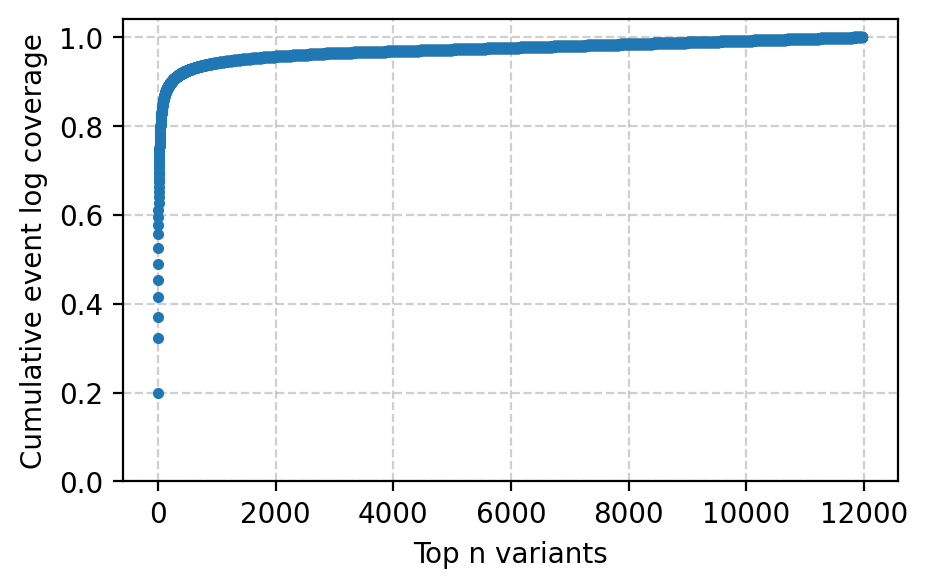

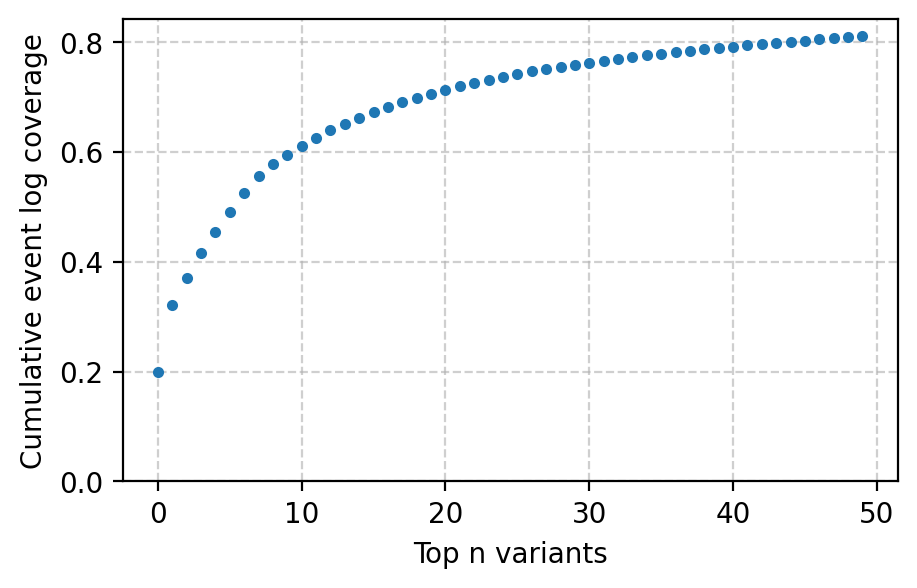

In [5]:
top_variants_data = list(top_variants(log).values())

plt.figure(figsize=(5, 3))
plt.plot(top_variants_data, '.')
plt.ylim(bottom=0)
plt.xlabel("Top n variants")
plt.ylabel("Cumulative event log coverage")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

plt.figure(figsize=(5, 3))
plt.plot(top_variants_data[:50], '.')
plt.ylim(bottom=0)
plt.xlabel("Top n variants")
plt.ylabel("Cumulative event log coverage")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

## 2. Filtering noise out of the log file

In [6]:
pct_filter = 0.7
label = f'{pct_filter*100:03.0f}'
label

'070'

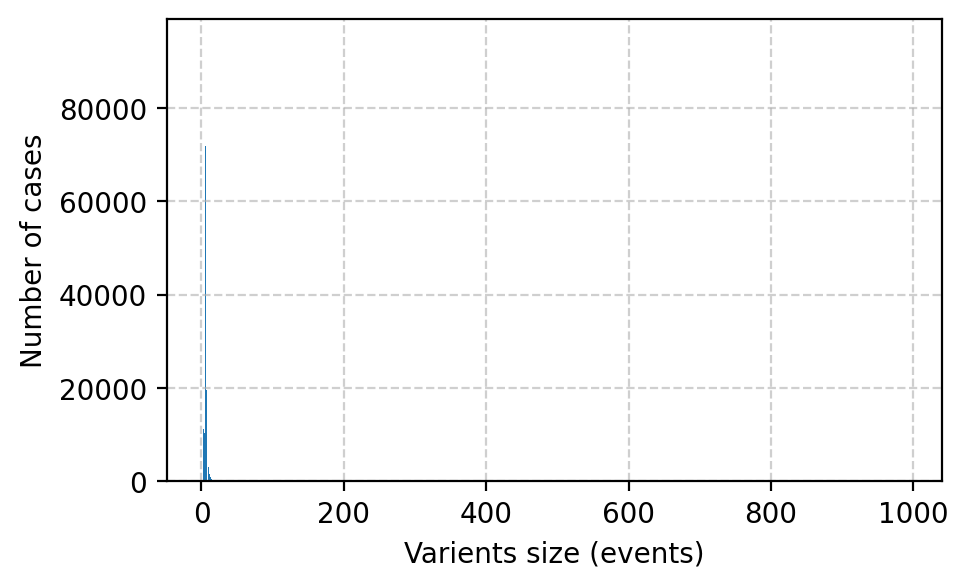

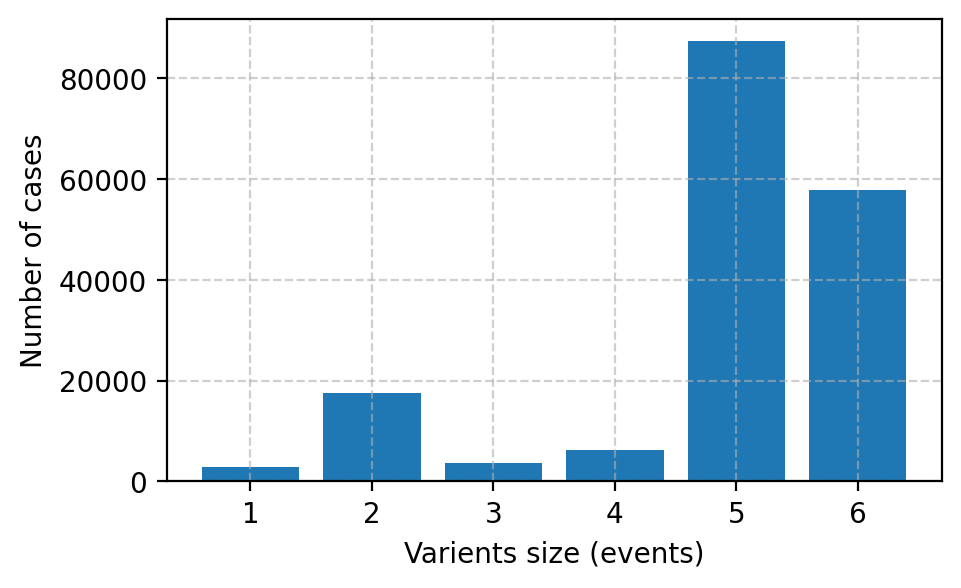

In [7]:
plot_case_count_vs_variants_size(log)
log = filter_most_freq_pct_variants(log, pct_filter)
# log = pm4py.filter_variants_top_k(log, 1)
plot_case_count_vs_variants_size(log)

# save left over for analysis later
merged_df = pm4py.convert_to_dataframe(log_original).merge(pm4py.convert_to_dataframe(log), how='outer', indicator=True)
leftover_events = merged_df[merged_df['_merge'] == 'left_only']
# print(len(log_original), len(log), len(log_original) - len(log),len(leftover_events))

In [8]:
# draw DFG
dfg, sa, ea = pm4py.discover_dfg(log)
# pm4py.view_dfg(dfg, sa, ea)
pm4py.save_vis_dfg(dfg, sa, ea, f'dfg_{label}.png')

''

In [9]:
print(f"Vocabulary: {vocab_size} activities")
print(f"Number of events: {len(log):,d}")
print(f"Number of cases: {len(pm4py.get_trace_attribute_values(log, "case:concept:name")):,d}")
print(f"Number of variants: {len(pm4py.get_variants(log)):,d}")

Vocabulary: 42 activities
Number of events: 858,270
Number of cases: 175,606
Number of variants: 19


## 3. Sequence Creation

We transform the event log into a set of sequences (prefixes) and targets (next event). 
For example, if a case is `[A, B, C]`, we generate:
- Input: `[A]`, Target: `B`
- Input: `[A, B]`, Target: `C`

In [10]:
sequences = []
next_events = []

grouped = log.groupby(case_col)

for case_id, group in grouped:
    # Ensure sorted by time
    group = group.sort_values(time_col)
    acts = group[act_col].tolist()
    act_indices = [activity_to_idx[a] for a in acts]
    
    # Create sliding windows
    for i in range(1, len(act_indices)):
        seq = act_indices[:i]
        target = act_indices[i]
        sequences.append(seq)
        next_events.append(target)

print(f"Generated {len(sequences):,d} training sequences.")
print("Example:", sequences[10], "->", next_events[10])

Generated 682,664 training sequences.
Example: [7] -> 9


## 4. PyTorch Dataset and Model

We define a custom Dataset to handle padding, and a simple LSTM model.

In [11]:
class EventLogDataset(Dataset):
    def __init__(self, sequences, targets, max_len=10):
        self.sequences = sequences
        self.targets = targets
        self.max_len = max_len
        
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        seq = self.sequences[idx]
        target = self.targets[idx]
        
        # Pre-padding
        if len(seq) < self.max_len:
            padded_seq = [0] * (self.max_len - len(seq)) + seq 
        else:
            padded_seq = seq[-self.max_len:]
            
        return torch.tensor(padded_seq, dtype=torch.long), torch.tensor(target, dtype=torch.long)

class NextEventLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim=32, hidden_dim=64):
        super(NextEventLSTM, self).__init__()
        # padding_idx=0 means the embedding vector at index 0 will be all zeros and not updated if we want
        # Note: In our mapping, 0 is a valid activity. 
        # Ideally we should reserve 0 for padding. For simplicity here we ignore proper masking.
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)
    
    def forward(self, x):
        embeds = self.embedding(x)
        # out: [batch, seq_len, hidden]
        out, _ = self.lstm(embeds)
        # Take the output of the last time step
        last_out = out[:, -1, :]
        logits = self.fc(last_out)
        return logits

## 5. Training

We split the data and train the model.

In [12]:
start_time = time.time()

from sklearn.model_selection import train_test_split

# Split
X_train, X_test, y_train, y_test = train_test_split(sequences, next_events, test_size=0.2, random_state=42)

# Dataloaders
train_ds = EventLogDataset(X_train, y_train)
test_ds = EventLogDataset(X_test, y_test)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)

# Model Init
model = NextEventLSTM(vocab_size).to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

# Training Loop
epochs = 10
print("Starting training...")

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for data, target in train_loader:
        optimizer.zero_grad()
        output = model(data.to(device))
        loss = criterion(output, target.to(device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    avg_loss = total_loss / len(train_loader)
    if (epoch+1) % 2 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

train_time = time.time() - start_time

Starting training...
Epoch 2/10, Loss: 0.4078
Epoch 4/10, Loss: 0.4076
Epoch 6/10, Loss: 0.4072
Epoch 8/10, Loss: 0.4075
Epoch 10/10, Loss: 0.4077


## 6. Evaluation

Check accuracy on the test set.

In [13]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for data, target in test_loader:
        outputs = model(data.to(device))
        _, predicted = torch.max(outputs.data, 1)
        total += target.size(0)
        correct += (predicted == target.to(device)).sum().item()

print(f'Accuracy of the model on test sequences: {100 * correct / total:.2f}%')
Accuracy = 100 * correct / total

Accuracy of the model on test sequences: 79.27%


## 7. Prediction Demo

Let's predict the next event for a sample sequence.

In [14]:
def predict_next(sequence, model, max_len=10):
    model.eval()
    # Encode
    idxs = [activity_to_idx.get(a, 0) for a in sequence]
    # Pad
    if len(idxs) < max_len:
        padded = [0] * (max_len - len(idxs)) + idxs
    else:
        padded = idxs[-max_len:]
        
    tensor_in = torch.tensor([padded], dtype=torch.long)
    with torch.no_grad():
        output = model(tensor_in.to(device))
        _, predicted_idx = torch.max(output, 1)
        
    return idx_to_activity[predicted_idx.item()]

# Test
tmp = list(top_variants(log))[:5]
# display(tmp[3])
sample_seq, next_activity = tmp[3][:-1], tmp[3][-1]
prediction = predict_next(sample_seq, model)
print(f"Sequence: {sample_seq}")
print(f"Predicted Next: {prediction}")
print(f"Actual Next: {next_activity}")

Sequence: ('Create Purchase Order Item', 'Vendor creates invoice', 'Record Goods Receipt', 'Record Invoice Receipt', 'Remove Payment Block')
Predicted Next: Clear Invoice
Actual Next: Clear Invoice


## 8. Test model on the filtered out cases/variants

In [15]:
sequences = []
next_events = []

grouped = leftover_events.groupby(case_col)

for case_id, group in grouped:
    # Ensure sorted by time
    group = group.sort_values(time_col)
    acts = group[act_col].tolist()
    act_indices = [activity_to_idx[a] for a in acts]
    
    # Create sliding windows
    for i in range(1, len(act_indices)):
        seq = act_indices[:i]
        target = act_indices[i]
        sequences.append(seq)
        next_events.append(target)

In [16]:
model.eval()
correct = 0
total = 0

# Dataloaders
test_ds = EventLogDataset(sequences, next_events)

test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)

with torch.no_grad():
    for data, target in test_loader:
        outputs = model(data.to(device))
        _, predicted = torch.max(outputs.data, 1)
        total += target.size(0)
        correct += (predicted == target.to(device)).sum().item()

print(f'Accuracy of the model on "leftover" sequences: {100 * correct / total:.2f}%')
Accuracy_lo = 100 * correct / total

Accuracy of the model on "leftover" sequences: 30.80%


## 7. Report results to 'results.csv'

In [17]:
# timestamp, label, avg_loss, accuracy, time, num_events, num_cases, num_variants
with open(results_file, 'a') as f:
    f.write(f'{datetime.now().strftime("%Y-%m-%d %H:%M:%S")}\t{label}%\t{avg_loss:.4f}\t{Accuracy:.2f}%\t{Accuracy_lo:.2f}%\t{train_time:.4f}\t{len(log):,d}\t{len(pm4py.get_trace_attribute_values(log, "case:concept:name")):,d}\t{len(pm4py.get_variants(log)):,d}\n')